In [5]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO



# Classification Datasets

In [6]:
def preprocessing(df, y_label):
    '''

    Parameters:
        df: pandas dataframe
        y_label: str
    Returns:
        Xtrain: np.ndarray
        Ytrain: np.ndarray
        Xtest: np.ndarray
        Ytest: np.ndarray

    '''
    #Get columns with exactly two unique non-numeric values
    cols_with_two_unique_values = [col for col in df.columns if df[col].nunique(dropna=False) == 2 and not pd.api.types.is_numeric_dtype(df[col])]

    #replacing unique values with 0 and 1 (this reduces unnecessary columns after one-hot encoding)
    for col in cols_with_two_unique_values:
        values = df[col].unique()
        df[col] = df[col].replace({values[0]: 0, values[1]: 1})

    #One-hot encoding remaining columns and replace boolean values with binary values
    df = pd.get_dummies(df).replace({False: 0, True: 1})

    #Drop rows with missing values (if any)
    df = df.dropna()
    #print(df.columns['Occupancy'].unique())
    #split into train and test set
    df_train = df.sample(frac=0.8, axis=0)
    df_test = df.drop(df_train.index)

    #Choose target feature
    y_train = df_train[f'{y_label}'].to_numpy()
    X_train = df_train.drop(columns=[f'{y_label}']).to_numpy()

    y_test = df_test[f'{y_label}'].to_numpy()
    X_test = df_test.drop(columns=[f'{y_label}']).to_numpy()
    return X_train, y_train, X_test, y_test




#Reading marketing dataset with most number of features and instances
marketing_df = pd.read_csv('bank+marketing/bank-additional/bank-additional/bank-additional-full.csv', sep=';')
#Preprocess data
Xtrain_marketing, ytrain_marketing, Xtest_marketing, ytest_marketing = preprocessing(marketing_df, y_label='y')


#Reading occupancy data
occupancy_df1 = pd.read_csv('occupancy+detection/datatest.txt', sep=',')
#occupancy_df2 = pd.read_csv('occupancy+detection/datatest2.txt', sep=',')
#occupancy_df3 = pd.read_csv('occupancy+detection/datatraining.txt', sep=',')
#Combining all dataframes into one
#occupancy_df = pd.concat([occupancy_df1, occupancy_df2, occupancy_df3]).reset_index(drop=True)
#drop date feature as there are all values are unique and will not help the learning process
occupancy_df = occupancy_df1.drop(columns='date')

#Preprocess data
Xtrain_occupancy, ytrain_occupancy, Xtest_occupancy, ytest_occupancy = preprocessing(occupancy_df, y_label='Occupancy')



/tmp/ipykernel_25362/1631721368.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({values[0]: 0, values[1]: 1})
/tmp/ipykernel_25362/1631721368.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.get_dummies(df).replace({False: 0, True: 1})


# Linear Classification with Gradient Descent

In [7]:
#sigmoid function
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def log1pexp(z):
    # np.logaddexp(0, z) computes log(1 + exp(z)) stably
    return np.logaddexp(0, z)


#logistic regression function can be simplified which results in -yz + log(1+e^z)
def log_loss_single_sample(theta, x, y):
    z = theta.T @ x
    return log1pexp(z) - y * z


def log_loss(theta, X, y):
    z = X @ theta
    #loss_vec = - (y * np.log(sigmoid(z)) + (1 - y) * np.log(1 - sigmoid(z)))
    #loss_vec = np.log(1 + np.exp(z)) -(y * z)
    loss_vec = log1pexp(z) - y * z
    return np.mean(loss_vec)


#gradient of logistic regression loss function
#https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d
def gradient(theta, x, y):
    z = theta.T @ x
    pred = sigmoid(z)
    grad = (pred - y) * x
    return grad



#function to shuffle data
def shuffle_data(X, y):
    assert len(X) == len(y), "X and y must have the same number of samples"
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]



def steplength_bolddriver(theta, x, y, d, alpha_old, alpha_plus, alpha_minus):

    current_loss = (log_loss_single_sample(theta, x, y))
    alpha_min = 1e-9
    alpha = alpha_old*alpha_plus
    remaining_iterations = 20
    while current_loss - float((log_loss_single_sample((theta - alpha * d), x, y))) <=0 and remaining_iterations > 0:
        alpha *= alpha_minus
        remaining_iterations-=1

    return max(alpha, alpha_min)



def sgd_using_bolddriver(theta_0, learning_rate, t_max, eps, X_train, y_train):

    theta = theta_0
    loss_changes = []
    theta_values = [theta]

    for t in range(t_max):
        X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)

        #calculate loss before update
        loss_before = log_loss(theta, X_train_shuffled, y_train_shuffled)

        #for each sample update parameter theta
        for i in range(len(X_train_shuffled)):

            #Calculate gradient at i-th sample
            g = gradient(theta, X_train_shuffled[i], y_train_shuffled[i])
            
            #choose learning rate with the bold-driver heuristic
            learning_rate = steplength_bolddriver(theta, X_train_shuffled[i], y_train_shuffled[i], g, learning_rate, 1.1, 0.5)

            
            #update parameter
            theta = theta - learning_rate * g



        #loss after update
        loss_after = log_loss(theta, X_train_shuffled, y_train_shuffled)
        
        loss_change = abs(loss_after - loss_before)
        loss_changes.append(loss_change)
        theta_values.append(theta)


        if np.linalg.norm(learning_rate * g) < eps:
            print("Finished in {} epochs".format(t+1))

            return loss_changes, theta_values

    print(f'No convergence in {t_max} epochs')
    return loss_changes, theta_values



def adagrad_steplength(gradient, h_sum, mu_0, epsilon=1e-8):
    """
    Adagrad stepsize update.

    Parameters:
        gradient (np.array): Current gradient vector (n,)
        h (np.array): Accumulated squared gradients (historical sum), shape (n,)
        mu_0 (np.araray): Initial learning rate (μ₀)
        epsilon (float): Small constant to prevent division by zero

    Returns:
        mu (np.array): Adjusted stepsizes for each parameter
        h_new (np.array): Updated historical sum of squared gradients
    """

    h_sum += np.power(gradient, 2)
    mu = mu_0/np.sqrt(h_sum + epsilon)
    return mu, h_sum


def sgd_using_adagrad(theta_0, h_initial, t_max, eps, X_train, y_train):

    theta = theta_0
    h_sum = h_initial

    loss_changes = []
    theta_values = [theta]

    for t in range(t_max):
        X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)

        #calculate loss before update
        loss_before = log_loss(theta, X_train_shuffled, y_train_shuffled)

        #for each sample update parameter theta
        for i in range(len(X_train_shuffled)):

            #Calculate gradient at i-th sample
            g = gradient(theta, X_train_shuffled[i], y_train_shuffled[i])
            #choose learning rate with the adagrad heuristic
            learning_rate, h_sum = adagrad_steplength(g, h_sum, mu_0=0.1)

        
            #update parameter
            theta = theta - learning_rate * g



        #loss after update
        loss_after = log_loss(theta, X_train_shuffled, y_train_shuffled)
        
        loss_change = abs(loss_after - loss_before)
        loss_changes.append(loss_change)
        theta_values.append(theta)


        if np.linalg.norm(learning_rate * g) < eps:
            
            print("Finished in {} epochs".format(t+1))
            
            return loss_changes, theta_values

    print(f'No convergence in {t_max} epochs')
    return loss_changes, theta_values




def log_reg_SGD(learning_rate, t_max, eps, X_train, y_train, steplength_function):
    ''''
    Parameters:
        learning_rate (float): Initial learning rate
        t_max (int): Maximum number of epochs
        eps (float): Tolerance/ Stopping criteria
        X_train (np.ndarray): Training data features
        y_train (np.array): Training data targets
        steplength_function (str): 'adagrad' or 'bolddriver'
    Returns:
        loss_changes (list): List of loss change values
        theta_values List(np.array): List of parameters calculated until convergence
    '''

    #Initialize parameter

    theta_0 = np.zeros(X_train.shape[1])

    if steplength_function == 'adagrad':

        h_initial = np.zeros(X_train.shape[1])
        return sgd_using_adagrad(theta_0, h_initial, t_max, eps, X_train, y_train)
    elif steplength_function == 'bolddriver':
        return sgd_using_bolddriver(theta_0, learning_rate, t_max, eps, X_train, y_train)
    else:
        raise ValueError('Unknown steplength function {}'.format(steplength_function))


def calculate_log_loss(theta, X_test, y_test):

    #compute predictions using test set
    z = X_test @ theta
    y_hat = sigmoid(z)
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
    #calculate log-loss
    log_loss = - np.mean(y_test * np.log(y_hat) + (1 - y_test) * np.log(1 - y_hat))
    return log_loss

Learning logistic regression model for the occupancy dataset while using bold-driver as the steplenght function

Finished in 7 epochs


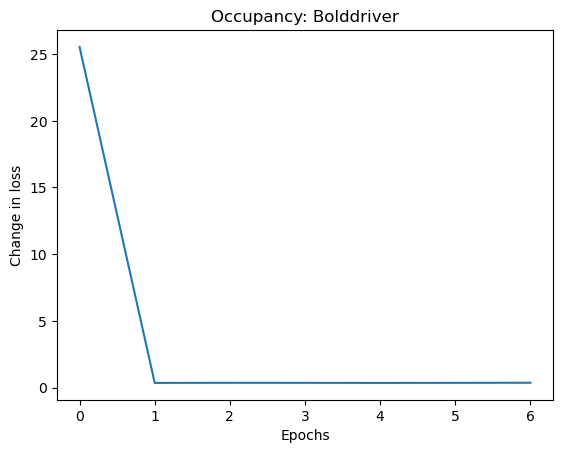

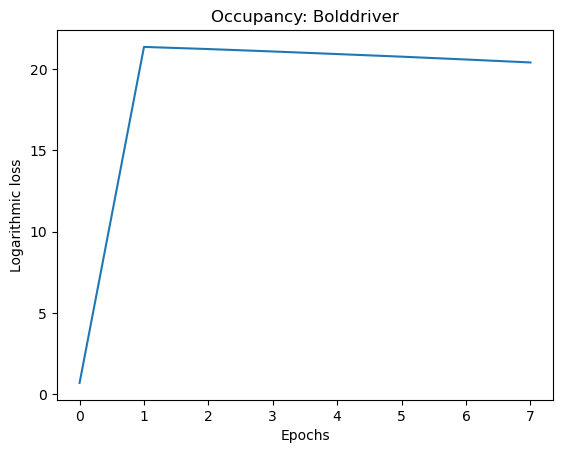

In [12]:

loss_changes, theta_values = log_reg_SGD(1e-4, 500, 1e-10, Xtrain_occupancy, ytrain_occupancy, 'bolddriver')


log_loss_test_values = [calculate_log_loss(theta, Xtest_occupancy, ytest_occupancy) for theta in theta_values]



plt.plot(loss_changes)
plt.title('Occupancy: Bolddriver')
plt.xlabel('Epochs')
plt.ylabel('Change in loss')
plt.show()

plt.plot(log_loss_test_values)
plt.title('Occupancy: Bolddriver') 
plt.xlabel('Epochs')
plt.ylabel('Logarithmic loss')
plt.show()

During the first epoch, the model made large updates to the parameters, likely due to a high initial learning rate or steep gradients. These aggressive updates caused the loss to increase sharply, indicating that the model took a step in the wrong direction. This destructive update pushed the parameters into a poor region of the loss surface. In response, the Bold Driver algorithm reduced the learning rate drastically in an attempt to recover. However, the subsequent updates became too small to meaningfully improve the model. As a result, the loss remained flat and the change in loss diminished significantly, triggering the convergence condition after only seven epochs.

Using Adagrad steplength for the same dataset

No convergence in 100 epochs


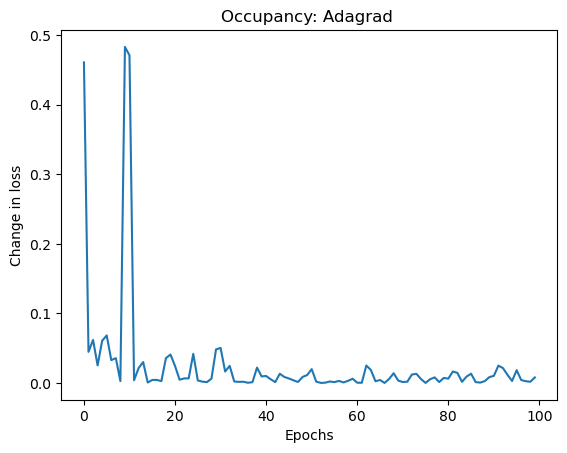

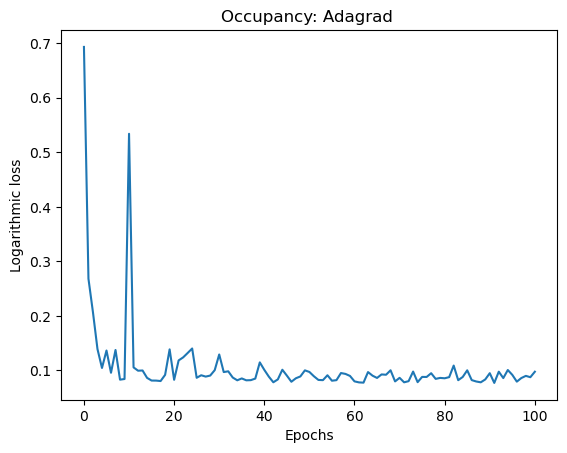

In [9]:
loss_changes, theta_values = log_reg_SGD(None, 100, 1e-10, Xtrain_occupancy, ytrain_occupancy, 'adagrad')


log_loss_test_values = [calculate_log_loss(theta, Xtest_occupancy, ytest_occupancy) for theta in theta_values]





plt.plot(loss_changes)
plt.title('Occupancy: Adagrad ')
plt.xlabel('Epochs')
plt.ylabel('Change in loss')
plt.show()

plt.plot(log_loss_test_values)
plt.title('Occupancy: Adagrad ')
plt.xlabel('Epochs')
plt.ylabel('Logarithmic loss')
plt.show()

The graphs show Adagrad's characteristic stabilizing behavior. The loss difference (almost) smoothly decreases to near zero over 100 epochs. The "Logarithmic loss" also shows a consistent downward trend. This pattern indicates that Adagrad is effectively adapting the learning rate per-parameter, with larger initial updates that gradually become more conservative as training progresses. Compared to the bolddriver algorithm the graph doesn't plateau and nears convergence. The algorithm's automatic learning rate adjustment appears well-suited to this problem.



For Marketing dataset

Finished in 2 epochs


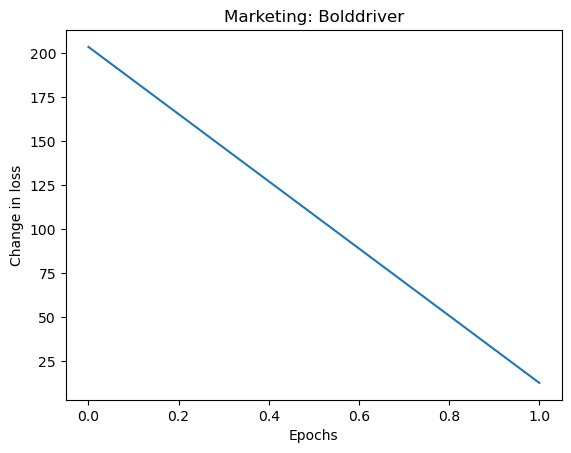

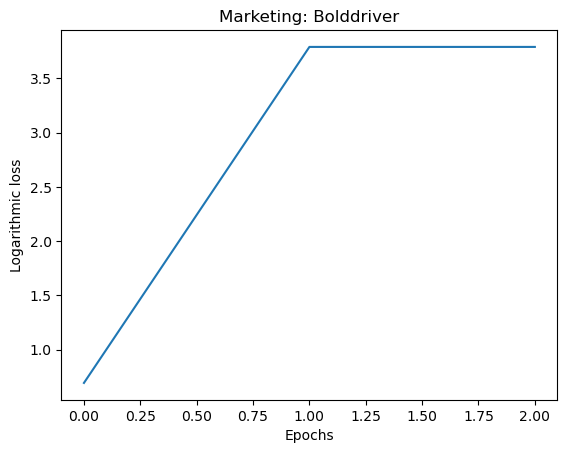

In [10]:
loss_changes, theta_values = log_reg_SGD(1e-4, 100, 1e-15, Xtrain_marketing, ytrain_marketing, 'bolddriver')


log_loss_test_values = [calculate_log_loss(theta, Xtest_marketing, ytest_marketing) for theta in theta_values]



plt.plot(loss_changes)
plt.title('Marketing: Bolddriver') 
plt.xlabel('Epochs')
plt.ylabel('Change in loss')
plt.show()

plt.plot(log_loss_test_values)
plt.title('Marketing: Bolddriver') 
plt.xlabel('Epochs')
plt.ylabel('Logarithmic loss')
plt.show()

This is similar to graph above for the Occupancy dataset which uses the Bolddriver algorithm. However, the model here converges after just two epochs.

Adagrad steplength

No convergence in 100 epochs


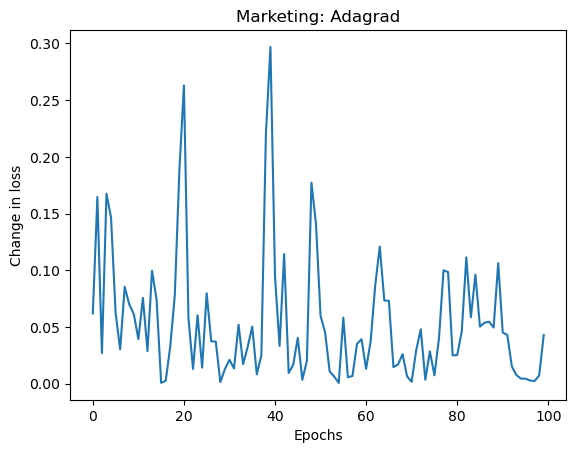

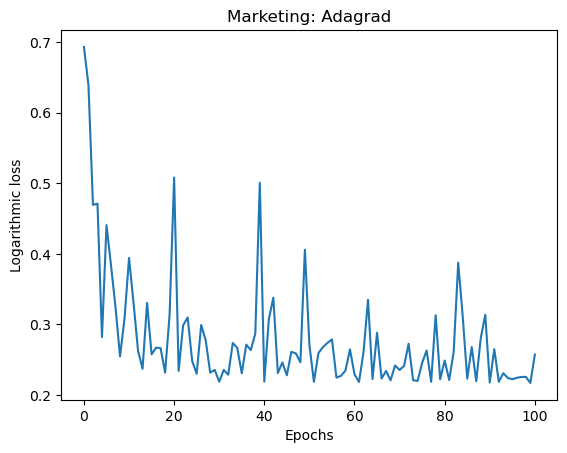

In [11]:
loss_changes, theta_values = log_reg_SGD(1e-9, 100, 1e-10, Xtrain_marketing, ytrain_marketing, 'adagrad')


log_loss_test_values = [calculate_log_loss(theta, Xtest_marketing, ytest_marketing) for theta in theta_values]





plt.plot(loss_changes)
plt.title('Marketing: Adagrad') 
plt.xlabel('Epochs')
plt.ylabel('Change in loss')
plt.show()

plt.plot(log_loss_test_values)
plt.title('Marketing: Adagrad') 
plt.xlabel('Epochs')
plt.ylabel('Logarithmic loss')
plt.show()

Compared to the Occupancy dataset, the grpah in this case is much spikier. This may be due to the prevalence of more noise in the data, which causes the step-lenght algorithm to use agressive learning rates.  